#  Principal Component Analysis

source: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data.
Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.
After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

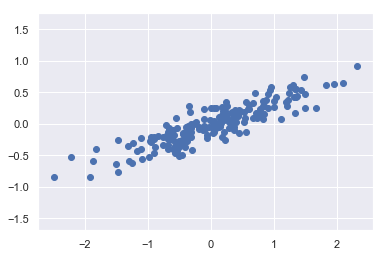

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables.
This is reminiscent of the linear regression data, but the problem setting here is slightly different: rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

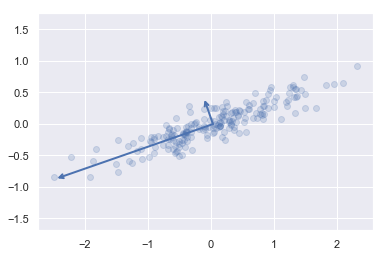

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color = 'b',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.

If we plot these principal components beside the original data, we see the plots shown here:

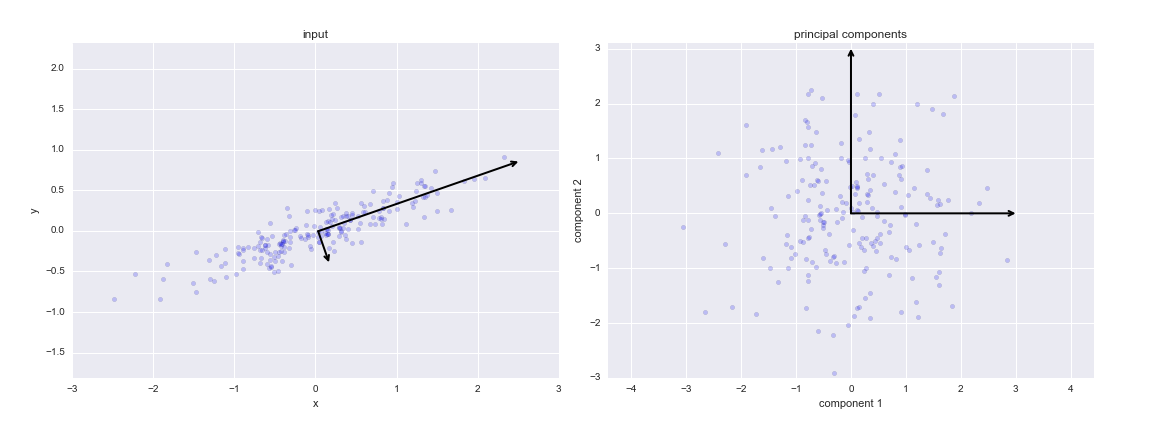

This transformation from data axes to principal axes is an *affine transformation*, which basically means it is composed of a translation, rotation, and uniform scaling.

While this algorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far-reaching applications in the world of machine learning and data exploration.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [7]:
pca = PCA(n_components=1)
#clf = PCA(0.95) # keep 95% of variance
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

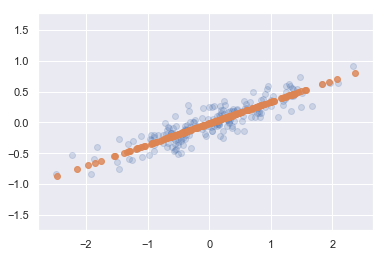

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits data.
We start by loading the data:

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

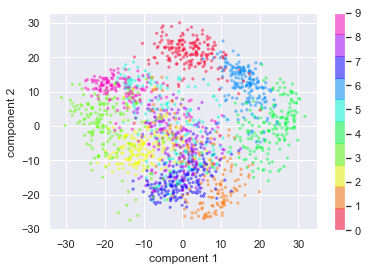

In [11]:
plt.scatter(projected[:, 0], projected[:, 1],
            s=10,
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('gist_rainbow', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

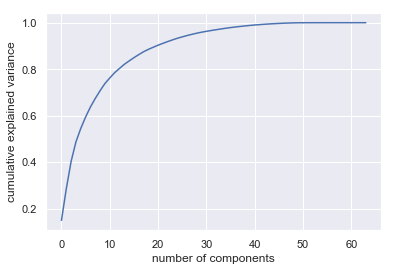

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## Example: Eigenfaces

An example of using a PCA projection as a feature selector for facial recognition.
let's take a look at the facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. :

In [23]:
# from sklearn.datasets import fetch_lfw_people
# faces = fetch_lfw_people(min_faces_per_person=60)

from sklearn.datasets import fetch_lfw_people
faces2 = fetch_lfw_people(download_if_missing=False, min_faces_per_person=60)

print(faces2.target_names)
print(faces2.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

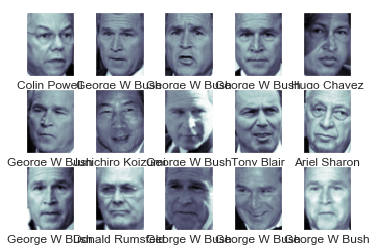

In [24]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Let's take a look at the principal axes that span this dataset.
Because this is a large dataset, we will use ``RandomizedPCA``—it contains a randomized method to approximate the first $N$ principal components much more quickly than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).
We will take a look at the first 150 components:

In [26]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors,"
so these types of images are often called "eigenfaces").
As you can see in this figure, they are as creepy as they sound:

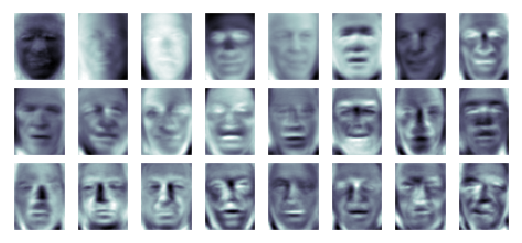

In [27]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

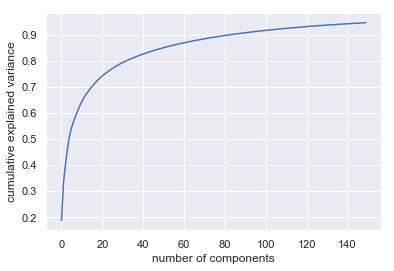

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [29]:
# Compute the components and projected faces
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

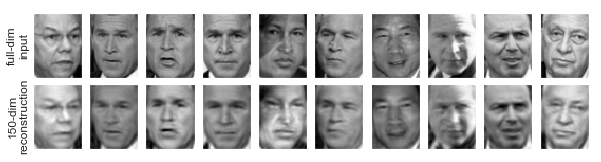

In [30]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.
This visualization makes clear why the PCA feature selection can be so successful when used as a **preprocessor to extract more meaningful features**; : although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image.

What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

{'svc__C': 10, 'svc__gamma': 0.001}


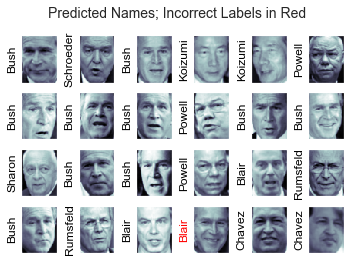

In [57]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# make our pipline
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)



#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

# fit the model
# model.fit(Xtrain, ytrain)
# param_grid = {'svc__C': [1, 5, 10, 50],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
param_grid = {'svc__C': [10],
              'svc__gamma': [0.001]}
grid = GridSearchCV(model, param_grid, cv=5)

grid.fit(Xtrain, ytrain)
print(grid.best_params_)
model = grid.best_estimator_



yfit = model.predict(Xtest)

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);


                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

        micro avg       0.85      0.85      0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



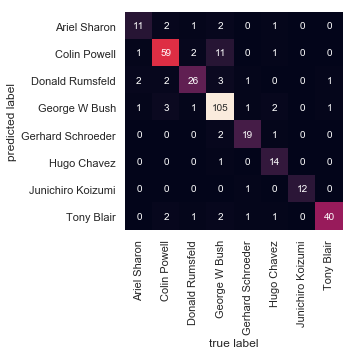

In [58]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

#confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');


## Principal Component Analysis Cons

PCA's main weakness is that it tends to be highly affected by outliers in the data.
For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components.
Scikit-Learn contains a couple interesting variants on PCA, including ``RandomizedPCA`` and ``SparsePCA``, both also in the ``sklearn.decomposition`` submodule.
``RandomizedPCA``, which we saw earlier, uses a non-deterministic method to quickly approximate the first few principal components in very high-dimensional data, while ``SparsePCA`` introduces a regularization term that serves to enforce sparsity of the components.

